### To identify various topics from the CORONA-19 based texual data basis following quetions:
 1. What is known about transmission, incubation, and environmental stability? 
 2. What do we know about COVID-19 risk factors?
 3. What do we know about vaccines and therapeutics?
 4. What do we know about diagnostics and surveillance?
 5. What do we know about non-pharmaceutical interventions?
 6. What has been published about ethical and social science considerations?
 7. What do we know about virus genetics, origin, and evolution?
 8. What has been published about medical care?


In [1]:
import numpy as np 
import pandas as pd 
import os
import json
import glob
import sys
import re
from pprint import pprint

In [2]:
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
data_root_path = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\data\\'

In [4]:
json_filenames = glob.glob(f'{data_root_path}/in/2020-03-13/**/*.json', recursive=True)

In [5]:
len(json_filenames)

13202

In [6]:
def return_corona_df(json_filenames, df):
    for file_name in json_filenames:
        source = file_name.split('\\')[-2]

        row = {"doc_id": None, "source": None, "title": None,
              "abstract": None, "text_body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            doc_id = data['paper_id']
            row['doc_id'] = doc_id
            row['title'] = data['metadata']['title'].replace(',', ' ').replace('\n', ' ')
            

            # Now need all of abstract. Put it all in 
            # a list then use str.join() to split it
            # into paragraphs. 

            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = " ".join(abstract_list)
            abstract = abstract.replace(',', ' ').replace('\n', ' ')
            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = " ".join(body_list)
            body = body.replace(',', ' ').replace('\n', ' ')
            
            row['text_body'] = body
            
            row['source'] = source
            
            # Add to the dataframe. 

            df = df.append(row, ignore_index=True)
    
    return df

In [7]:
corona_features = {"doc_id": [None], "source": [None], "title": [None],
                  "abstract": [None], "text_body": [None]}
corona_df = pd.DataFrame.from_dict(corona_features)
corona_df = return_corona_df(json_filenames, corona_df)
corona_df = corona_df.dropna().reset_index(drop=True)

In [8]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13202 entries, 0 to 13201
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   doc_id     13202 non-null  object
 1   source     13202 non-null  object
 2   title      13202 non-null  object
 3   abstract   13202 non-null  object
 4   text_body  13202 non-null  object
dtypes: object(5)
memory usage: 515.8+ KB


In [9]:
corona_df.head(10)

doc_id           source  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb  biorxiv_medrxiv   
1  004f0f8bb66cf446678dc13cf2701feec4f36d76  biorxiv_medrxiv   
2  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b  biorxiv_medrxiv   
3  013d9d1cba8a54d5d3718c229b812d7cf91b6c89  biorxiv_medrxiv   
4  01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18  biorxiv_medrxiv   
5  01e3b313e78a352593be2ff64927192af66619b5  biorxiv_medrxiv   
6  02201e4601ab0eb70b6c26480cf2bfeae2625193  biorxiv_medrxiv   
7  0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5  biorxiv_medrxiv   
8  029c1c588047f1d612a219ee15494d2d19ff7439  biorxiv_medrxiv   
9  03ce432f27c7df6af22b92245a614db2ecb5de5f  biorxiv_medrxiv   

                                               title  \
0  The RNA pseudoknots in foot-and-mouth disease ...   
1  Healthcare-resource-adjusted vulnerabilities t...   
2  Real-time  MinION-based  amplicon sequencing f...   
3  Assessing spread risk of Wuhan novel coronavir...   
4  TWIRLS  an automated topic-wise inference meth...   
5  Title: Viruses are a dominant driver of protei...   
6  The impact of regular school closure on season...   
7  Carbon Nanocarriers Deliver siRNA to Intact Pl...   
8  Protective Population Behavior Change in Outbr...   
9  A hidden gene in astroviruses encodes a cell-p...   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1                                                      
2  Infectious bronchitis (IB) causes significant ...   
3  Background: A novel coronavirus (2019-nCoV) em...   
4  Faced with the current large-scale public heal...   
5  Viruses interact with hundreds to thousands of...   
6  School closure is often considered as an optio...   
7  Post-transcriptional gene silencing (PTGS) is ...   
8                                                      
9  Human astroviruses are small nonenveloped viru...   

                                           text_body  
0  VP3  and VP0 (which is further processed to VP...  
1  The 2019-nCoV epidemic has spread across China...  
2  Infectious bronchitis (IB)  which is caused by...  
3  In December 2019  a cluster of patients with p...  
4  The sudden outbreak of the new coronavirus (SA...  
5  The copyright holder for this preprint (which ...  
6  they affect seasonal influenza dynamics. The m...  
7  siRNA without relying on plant transformation ...  
8  estimation is complicated  however  by efforts...  
9  Humans astroviruses (HAstVs) belong to genus M...

In [10]:
corona_df.to_csv(data_root_path+'out/kaggle_covid-19.csv')

In [11]:
corona_df.iloc[:10,:].to_csv(data_root_path+'out/kaggle_covid-19_top10.csv')

In [12]:
# prepare stopwords
stop_words = stopwords.words('english')

In [13]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13202 entries, 0 to 13201
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   doc_id     13202 non-null  object
 1   source     13202 non-null  object
 2   title      13202 non-null  object
 3   abstract   13202 non-null  object
 4   text_body  13202 non-null  object
dtypes: object(5)
memory usage: 515.8+ KB


In [14]:
# Convert to list
data = corona_df.text_body.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['VP3 and VP0 (which is further processed to VP2 and VP4 during virus '
 'assembly) (6). The P2 64 and P3 regions encode the non-structural proteins '
 '2B and 2C and 3A 3B (1-3) (VPg) 3C pro and 4 structural protein-coding '
 'region is replaced by reporter genes allow the study of genome 68 '
 'replication without the requirement for high containment (9 10) ( figure 1A '
 '). The FMDV 5′ UTR is the largest known picornavirus UTR comprising '
 'approximately 1300 71 nucleotides and containing several highly structured '
 'regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold '
 'into a single large stem loop termed the S-fragment followed by a The PKs '
 'were originally predicted in 1987 and consist of two to four tandem repeats '
 'of a ~48 86 nucleotide region containing a small stem loop and downstream '
 'interaction site (figure 1B) 87 (12). Due to the sequence similarity between '
 'the PKs (figure 1C) it is speculated that they 88 were formed by duplication

In [15]:
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['vp', 'and', 'vp', 'which', 'is', 'further', 'processed', 'to', 'vp', 'and', 'vp', 'during', 'virus', 'assembly', 'the', 'and', 'regions', 'encode', 'the', 'non', 'structural', 'proteins', 'and', 'and', 'vpg', 'pro', 'and', 'structural', 'protein', 'coding', 'region', 'is', 'replaced', 'by', 'reporter', 'genes', 'allow', 'the', 'study', 'of', 'genome', 'replication', 'without', 'the', 'requirement', 'for', 'high', 'containment', 'figure', 'the', 'fmdv', 'utr', 'is', 'the', 'largest', 'known', 'picornavirus', 'utr', 'comprising', 'approximately', 'nucleotides', 'and', 'containing', 'several', 'highly', 'structured', 'regions', 'the', 'first', 'nucleotides', 'at', 'the', 'end', 'are', 'predicted', 'to', 'fold', 'into', 'single', 'large', 'stem', 'loop', 'termed', 'the', 'fragment', 'followed', 'by', 'the', 'pks', 'were', 'originally', 'predicted', 'in', 'and', 'consist', 'of', 'two', 'to', 'four', 'tandem', 'repeats', 'of', 'nucleotide', 'region', 'containing', 'small', 'stem', 'loop',

In [16]:
# Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['vp', 'and', 'vp', 'which', 'is', 'further', 'processed', 'to', 'vp', 'and', 'vp', 'during', 'virus', 'assembly', 'the', 'and', 'regions', 'encode', 'the', 'non', 'structural', 'proteins', 'and', 'and', 'vpg', 'pro', 'and', 'structural', 'protein', 'coding', 'region', 'is', 'replaced', 'by', 'reporter', 'genes', 'allow', 'the', 'study', 'of', 'genome', 'replication', 'without', 'the', 'requirement', 'for', 'high', 'containment', 'figure', 'the', 'fmdv', 'utr', 'is', 'the', 'largest', 'known', 'picornavirus', 'utr', 'comprising', 'approximately', 'nucleotides', 'and', 'containing', 'several', 'highly', 'structured', 'regions', 'the', 'first', 'nucleotides', 'at', 'the', 'end', 'are', 'predicted', 'to', 'fold', 'into', 'single', 'large', 'stem_loop', 'termed', 'the', 'fragment', 'followed', 'by', 'the', 'pks', 'were', 'originally', 'predicted', 'in', 'and', 'consist', 'of', 'two', 'to', 'four', 'tandem_repeats', 'of', 'nucleotide', 'region', 'containing', 'small', 'stem_loop', 'and', 'd

In [17]:
# Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 2000000
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['vp', 'process', 'virus', 'assembly', 'region', 'encode', 'non', 'structural', 'protein', 'vpg', 'pro', 'structural', 'protein', 'cod', 'region', 'replace', 'reporter', 'gene', 'allow', 'study', 'genome', 'replication', 'requirement', 'high', 'containment', 'figure', 'fmdv', 'utr', 'largest', 'know', 'picornavirus', 'utr', 'comprise', 'approximately', 'nucleotide', 'contain', 'several', 'highly', 'structured', 'region', 'first', 'nucleotide', 'end', 'predict', 'fold', 'single', 'large', 'stem_loop', 'termed', 'fragment', 'follow', 'pks', 'originally', 'predict', 'consist', 'tandem_repeat', 'nucleotide', 'region', 'contain', 'small', 'stem_loop', 'downstream', 'interaction', 'site', 'figure', 'due', 'sequence', 'similarity', 'pks', 'figure', 'speculate', 'form', 'duplication', 'event', 'viral', 'replication', 'probably', 'involve', 'recombination', 'pks', 'present', 'different', 'virus', 'isolate', 'strain', 'identify', 'less', 'pks', 'emphasise', 'potential', 'importance', 'viral', '

In [20]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 3), (6, 1), (7, 2), (8, 2), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 8), (26, 1), (27, 1), (28, 12), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 4), (39, 3), (40, 1), (41, 3), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 8), (53, 1), (54, 1), (55, 2), (56, 1), (57, 3), (58, 12), (59, 2), (60, 3), (61, 1), (62, 1), (63, 2), (64, 1), (65, 2), (66, 1), (67, 3), (68, 2), (69, 1), (70, 6), (71, 3), (72, 1), (73, 3), (74, 2), (75, 1), (76, 1), (77, 2), (78, 6), (79, 1), (80, 4), (81, 4), (82, 1), (83, 1), (84, 4), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 5), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 

In [21]:
id2word[0]

'aatii'

In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aatii', 3),
  ('able', 1),
  ('absence', 1),
  ('achieve', 1),
  ('addition', 2),
  ('advantage', 3),
  ('adverse', 1),
  ('aflii', 2),
  ('agree', 2),
  ('aii', 1),
  ('algorithm', 2),
  ('alighnment', 1),
  ('allow', 1),
  ('already', 1),
  ('also', 2),
  ('amount', 1),
  ('amplification', 1),
  ('analysis', 1),
  ('appear', 1),
  ('approximately', 1),
  ('aspect', 1),
  ('assay', 1),
  ('assemble', 2),
  ('assembly', 2),
  ('assess', 1),
  ('author_funder', 8),
  ('base_pair', 1),
  ('basic', 1),
  ('biorxiv_preprint', 12),
  ('blast', 1),
  ('calculate', 1),
  ('can', 1),
  ('cell', 3),
  ('change', 1),
  ('check', 1),
  ('clone', 3),
  ('co', 1),
  ('cod', 1),
  ('compare', 4),
  ('competent', 3),
  ('competition', 1),
  ('competitive', 3),
  ('complete', 1),
  ('comprise', 1),
  ('confer', 2),
  ('confirm', 1),
  ('conga', 1),
  ('consensus', 1),
  ('consist', 1),
  ('consistent', 3),
  ('construct', 1),
  ('construction', 1),
  ('contain', 8),
  ('containing', 1),
  ('contai

In [23]:
#Building the Topic Model
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
# View the topics in LDA model
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"influenza" + 0.044*"virus" + 0.036*"infection" + 0.034*"child" + '
  '0.031*"respiratory" + 0.020*"age" + 0.019*"study" + 0.018*"year" + '
  '0.016*"infant" + 0.015*"pandemic"'),
 (1,
  '0.040*"drug" + 0.038*"treatment" + 0.035*"activity" + 0.033*"effect" + '
  '0.030*"compound" + 0.024*"hiv" + 0.021*"treat" + 0.019*"antiviral" + '
  '0.019*"inhibitor" + 0.018*"use"'),
 (2,
  '0.044*"cell" + 0.027*"mouse" + 0.021*"cd" + 0.014*"infection" + '
  '0.013*"response" + 0.012*"lung" + 0.012*"tissue" + 0.009*"immune" + '
  '0.009*"macrophage" + 0.008*"level"'),
 (3,
  '0.028*"health" + 0.013*"public" + 0.012*"disease" + 0.012*"outbreak" + '
  '0.010*"country" + 0.009*"risk" + 0.008*"control" + 0.008*"report" + '
  '0.007*"hospital" + 0.007*"care"'),
 (4,
  '0.060*"protein" + 0.027*"peptide" + 0.026*"bind" + 0.013*"structure" + '
  '0.012*"domain" + 0.012*"surface" + 0.011*"residue" + 0.011*"region" + '
  '0.009*"membrane" + 0.008*"interaction"'),
 (5,
  '0.070*"cell" + 0.023*"fi

In [25]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.872738940952097

Coherence Score:  0.511792944363876


In [26]:
# Visualize the topics-keywords
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [27]:
#os.environ['MALLET_HOME'] = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\models\\mallet-2.0.8\\'

In [28]:
#os.environ.get('MALLET_HOME')

In [54]:
# # Building LDA Mallet Model
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# import os
# from gensim.models.wrappers import LdaMallet

# #os.environ['MALLET_HOME'] = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\models\\mallet-2.0.8'
# #os.environ.update({'MALLET_HOME': r'C:/Users/Abhishek Tanksali/OneDrive/AT_DATA/AT/Python_Workspace/HDFC_Bank/CORD-19/models/mallet-2.0.8/'})
# # mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet'  # update 
# mallet_path = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\models\\mallet-2.0.8\\bin\\mallet.bat' # update this path
# #os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
# #mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [30]:
# find the optimal number of topics for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('num_topics: ', num_topics)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

num_topics:  4
num_topics:  8
num_topics:  12
num_topics:  16
num_topics:  20
num_topics:  24
num_topics:  28
num_topics:  32
num_topics:  36


In [31]:
import pickle
model_root_path = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\models\\'
model_list_out = open(model_root_path+"model_list.pickle","wb")
pickle.dump(model_list, model_list_out)
model_list_out.close()

coherence_values_out = open(model_root_path+"coherence_values.pickle","wb")
pickle.dump(coherence_values, coherence_values_out)
coherence_values_out.close()

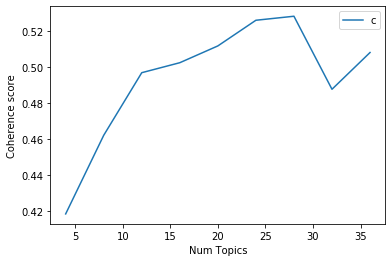

In [32]:
# Show graph
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.4183
Num Topics = 8  has Coherence Value of 0.4621
Num Topics = 12  has Coherence Value of 0.4969
Num Topics = 16  has Coherence Value of 0.5025
Num Topics = 20  has Coherence Value of 0.5118
Num Topics = 24  has Coherence Value of 0.5261
Num Topics = 28  has Coherence Value of 0.5283
Num Topics = 32  has Coherence Value of 0.4877
Num Topics = 36  has Coherence Value of 0.5081


In [34]:
# Select the model with num topics = 14 and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.026*"animal" + 0.024*"dog" + 0.018*"cat" + 0.016*"study" + '
  '0.015*"disease" + 0.015*"sample" + 0.012*"human" + 0.011*"specie" + '
  '0.010*"pig" + 0.008*"infection" + 0.008*"pathogen" + 0.007*"calf" + '
  '0.007*"positive" + 0.007*"diarrhea" + 0.006*"group" + 0.006*"may" + '
  '0.006*"prevalence" + 0.006*"day" + 0.006*"report" + 0.006*"farm" + '
  '0.006*"detect" + 0.006*"high" + 0.005*"ili" + 0.005*"sign" + 0.005*"fecal" '
  '+ 0.005*"find" + 0.005*"population" + 0.005*"also" + 0.005*"include" + '
  '0.005*"poultry"'),
 (1,
  '0.011*"cancer" + 0.010*"increase" + 0.010*"effect" + 0.009*"also" + '
  '0.009*"may" + 0.008*"response" + 0.008*"cell" + 0.008*"disease" + '
  '0.008*"tissue" + 0.007*"level" + 0.007*"study" + 0.007*"expression" + '
  '0.006*"induce" + 0.006*"treatment" + 0.006*"lung" + 0.006*"function" + '
  '0.006*"immune" + 0.006*"drug" + 0.006*"inflammatory" + 0.005*"tumor" + '
  '0.005*"gene" + 0.005*"show" + 0.005*"factor" + 0.005*"include" + '
  '0.005*"acti

In [35]:
# Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.107262 -0.097048       1        1  13.935349
8     -0.130838  0.128735       2        1  11.768627
7      0.082403  0.123820       3        1  11.528795
3     -0.081621  0.107923       4        1  11.474764
5      0.186201 -0.060929       5        1   9.261661
11    -0.002811  0.141306       6        1   8.996697
1      0.081806 -0.011236       7        1   8.084023
4      0.003394 -0.071016       8        1   7.280350
6      0.082181  0.060406       9        1   6.937716
10     0.183649 -0.157222      10        1   4.915057
0     -0.183075  0.058743      11        1   3.914474
9     -0.328549 -0.223482      12        1   1.902485, topic_info=          Term           Freq          Total Category  logprob  loglift
32        cell  409694.000000  409694.000000  Default  30.0000  30.0000
347      virus  220623.000000  220623.000000  Default  29.0000  29.0000
1220   patient  152335.000000  152335.000000  Default  28.0000  28.0000
282   sequence  133435.000000  133435.000000  Default  27.0000  27.0000
233    protein  197544.000000  197544.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
891     severe    4307.753418   31954.808594  Topic12  -4.8715   1.9581
347      virus    6454.140625  220623.859375  Topic12  -4.4672   0.4303
1220   patient    5884.532227  152335.656250  Topic12  -4.5596   0.7083
175        may    4962.205078  127331.796875  Topic12  -4.7301   0.7171
1116   illness    3235.808838   18621.181641  Topic12  -5.1576   2.2120

[981 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1933       3  0.040212          aa
1933       5  0.269686          aa
1933       8  0.666080          aa
1933      10  0.023829          aa
2283       3  0.999009  absorbance
...      ...       ...         ...
2796       8  0.044157    zoonotic
2796      11  0.729166    zoonotic
2796      12  0.171144    zoonotic
955        3  0.999034          µl
12380      3  0.998761        µmol

[2700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 8, 4, 6, 12, 2, 5, 7, 11, 1, 10])

In [55]:
pyLDAvis.save_html(vis, os.path.join(data_out_path,'covid-19-lda-gensim.html'))

In [36]:
# Finding the dominant topic in each document
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #print(row)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=50)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            10.0              0.5781   
1            1             3.0              0.6160   
2            2             6.0              0.5083   
3            3             3.0              0.4895   
4            4             6.0              0.2471   
5            5             6.0              0.3941   
6            6            11.0              0.6551   
7            7             7.0              0.3797   
8            8            11.0              0.5348   
9            9            10.0              0.3883   

                                            Keywords  \
0  rna, viral, sequence, protein, mrna, virus, fi...   
1  health, disease, public, country, risk, outbre...   
2  sequence, gene, use, genome, region, analysis,...   
3  health, disease, public, country, risk, outbre...   
4  sequence, gene, use, genome, region, analysis,...   
5  sequence, gene, use, genome, region, analysis,...   
6  model, number, use, datum, time, rate, case, v...   
7  use, sample, assay, ml, pcr, test, concentrati...   
8  model, number, use, datum, time, rate, case, v...   
9  rna, viral, sequence, protein, mrna, virus, fi...   

                                                Text  
0  VP3 and VP0 (which is further processed to VP2...  
1  The 2019-nCoV epidemic has spread across China...  
2  Infectious bronchitis (IB) which is caused by ...  
3  In December 2019 a cluster of patients with pn...  
4  The sudden outbreak of the new coronavirus (SA...  
5  The copyright holder for this preprint (which ...  
6  they affect seasonal influenza dynamics. The m...  
7  siRNA without relying on plant transformation ...  
8  estimation is complicated however by efforts t...  
9  Humans astroviruses (HAstVs) belong to genus M...

In [37]:
df_dominant_topic.shape[0]

13202

In [38]:
data_root_path

'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\data\\'

In [39]:
data_out_path = os.path.join(data_root_path + 'out\\')
df_dominant_topic.to_csv(os.path.join(data_out_path,'df_dominant_topic.csv'), index=False)

In [40]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7251   
1        1.0              0.8056   
2        2.0              0.9236   
3        3.0              0.9789   
4        4.0              0.7447   

                                            Keywords  \
0  animal, dog, cat, study, disease, sample, huma...   
1  cancer, increase, effect, also, may, response,...   
2  cell, mouse, cd, infection, fig, expression, i...   
3  health, disease, public, country, risk, outbre...   
4  virus, vaccine, hpv, human, viral, type, infec...   

                                                Text  
0  Cryptosporidium parvum is an intracellular pro...  
1  Recent advances in understanding the pathophys...  
2  at day 15 p.i. (Fig. 1b) . The high dose cause...  
3  I n the aftermath of severe acute respiratory ...  
4  Influenza viruses belong to the family of Orth...

In [41]:
sent_topics_sorteddf.shape[0]

12

In [42]:
sent_topics_sorteddf.to_csv(os.path.join(data_out_path,'sent_topics_sorteddf.csv'), index=False)

In [56]:
# # Topic distribution across documents
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics.head(200)